## Introducción:

# Proyecto Final: Telecomunicaciones: identificar operadores ineficaces

### Ejercicio

#### El servicio de telefonía virtual CallMeMaybe está desarrollando una nueva función que brindará a los supervisores y las supervisores información sobre los operadores menos eficaces. Se considera que un operador es ineficaz si tiene una gran cantidad de llamadas entrantes perdidas (internas y externas) y un tiempo de espera prolongado para las llamadas entrantes. Además, si se supone que un operador debe realizar llamadas salientes, un número reducido de ellas también será un signo de ineficacia.

- Lleva a cabo el análisis exploratorio de datos
- Identificar operadores ineficaces
- Prueba las hipótesis estadísticas

### Descripción de los datos

Los datasets contienen información sobre el uso del servicio de telefonía virtual CallMeMaybe. Sus clientes son organizaciones que necesitan distribuir gran cantidad de llamadas entrantes entre varios operadores, o realizar llamadas salientes a través de sus operadores. Los operadores también pueden realizar llamadas internas para comunicarse entre ellos. Estas llamadas se realizan a través de la red de CallMeMaybe.

El dataset comprimido `telecom_dataset_us.csv` contiene las siguientes columnas:

- `user_id`: ID de la cuenta de cliente
- `date`: fecha en la que se recuperaron las estadísticas
- `direction`: "dirección" de llamada (`out` para saliente, `in` para entrante)
- `internal`: si la llamada fue interna (entre los operadores de un cliente o clienta)
- `operator_id`: identificador del operador
- `is_missed_call`: si fue una llamada perdida
- `calls_count`: número de llamadas
- `call_duration`: duración de la llamada (sin incluir el tiempo de espera)
- `total_call_duration`: duración de la llamada (incluido el tiempo de espera)



El conjunto de datos `telecom_clients_us.csv` tiene las siguientes columnas:

- `user_id`: ID de usuario/a
- `tariff_plan`: tarifa actual de la clientela
- `date_start`: fecha de registro de la clientela

Haz una lista de 5 a 10 fuentes (documentación, artículos, etc) que usaste mientras trabajabas en el proyecto. Brinda explicaciones breves sobre las preguntas que cada fuente te ayudó a responder. Prepara una presentación con tus conclusiones. Puedes usar cualquier herramienta que quieras para hacer la presentación, pero debes enviarla en PDF. Coloca el enlace en el cuerpo del proyecto principal.

### Dashboards

1. Sugerencia 1
    1. Traza un histograma para la duración de la llamada
    2. Traza un gráfico circular que muestre la participación de las llamadas internas y externas
    3. Agrega un filtro para la "dirección" de llamadas
2. Sugerencia 2
    1. Traza un histograma que muestre el número de llamadas por día
    2. Traza un gráfico circular que muestre la participación de las llamadas internas y externas
    3. Agrega un filtro por tipo de llamada (interna o externa)

## Importar librerías:

In [1]:
# Se cargan todas las librerías que se puedan usar:
import pandas as pd
import numpy as np
import math as mt
from scipy.spatial.distance import mahalanobis
import scipy.stats as st
from scipy.stats import chi2
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram

## Cargar datos:

In [2]:
# Se cargan los datos empleando la librería pandas:

# Se carga la información de las llamadas:
data = pd.read_csv('telecom_dataset_us.csv')

# Se carga la información de los clientes:
clients = pd.read_csv('telecom_clients_us.csv')

## Análisis exploratorio de los datos (EDA):

### Dataframe "data":

#### Observación de los datos:

In [3]:
# Se visualizan las primeras 5 filas del dataframe:
print('Las primeras 5 filas del dataframe, son:')
data.head()

Las primeras 5 filas del dataframe, son:


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


#### Información general del dataframe:

In [4]:
# Se observa la información general del dataframe:

print('La información general del dataframe, es:\n')
data.info()

La información general del dataframe, es:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


#### Revisar si hay espacios en blanco al principio y al final de los nombres de las columnas:

In [5]:
# Se observa si hay espacios en blanco al principio o al final de los nombres de las columnas:

print('Los nombres de las columnas, son:')
data.columns

Los nombres de las columnas, son:


Index(['user_id', 'date', 'direction', 'internal', 'operator_id',
       'is_missed_call', 'calls_count', 'call_duration',
       'total_call_duration'],
      dtype='object')

#### Contar los valores ausentes de las columnas:

In [6]:
# Se cuenta la cantidad de valores ausentes para cada columna:

print('La cantidad de valores ausentes para cada columna, son:')
data.isna().sum()

La cantidad de valores ausentes para cada columna, son:


user_id                   0
date                      0
direction                 0
internal                117
operator_id            8172
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
dtype: int64

#### Se cuenta el número de filas totlamente duplicadas:

In [7]:
# Se cuenta la cantidad de filas totalmente duplicadas:

print('La cantidad de filas totalmente duplicadas, es:')
data.duplicated().sum()

La cantidad de filas totalmente duplicadas, es:


4900

#### Determinar si existen filas totalmente duplicadas:

In [8]:
# Se muestran las filas totalmente duplicadas para corroborar que no hay una falla en el sistema:

print('Las filas totalmente duplicadas, son:')
data[data.duplicated()]

Las filas totalmente duplicadas, son:


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
8,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,True,8,0,50
28,166377,2019-08-12 00:00:00+03:00,in,False,NaN,True,2,0,34
44,166377,2019-08-14 00:00:00+03:00,out,False,880026.0,False,10,1567,1654
45,166377,2019-08-14 00:00:00+03:00,in,False,NaN,True,1,0,3
51,166377,2019-08-15 00:00:00+03:00,out,False,880026.0,False,11,1413,1473
...,...,...,...,...,...,...,...,...,...
53869,168601,2019-11-25 00:00:00+03:00,in,False,952914.0,False,7,1229,1282
53874,168601,2019-11-26 00:00:00+03:00,in,False,952914.0,False,4,539,562
53875,168601,2019-11-26 00:00:00+03:00,in,False,NaN,True,3,0,35
53885,168603,2019-11-20 00:00:00+03:00,out,False,959118.0,True,3,0,89


**Conclusiones:**

* Se dispone con un total de **9 columnas** y **53902 filas**.

* El tipo de dato de las columnas **'user_id'**, **'direction'**, **'internal'**, **'is_missed_call'**, **'calls_count'**, **'call_duration'** y **'total_call_duration'** es el correcto.

* El tipo de dato de la columna **'date'** se debe cambiar de **object** a **datetime**.

* El tipo de dato de la columna **'operator_id'** se debe cambiar de **float** a **int**.

* Los nombres de las columnas están **todos en minúsculas** y las palabras está separadas por **"_"**.

* **No existen espacios en blanco al principio, ni al final** de los nombres de las columnas.

* **No hay valores ausentes en las columnas 'user_id', 'date', 'direction', 'is_missed_call', 'calls_count', 'call_duration'** y **'total_call_duration'**.

* **Hay 117 valores ausentes en la columna 'internal'**.

* **Hay 8172 valores ausentes en la columna 'operator_id'**.

* Al realizar el conteo de los valores duplicados se observa que aparentemente **hay 4900 filas totalmente duplicadas**.

* Al filtrar las filas duplicadas se comprueba que efectivamente **existen filas totalmente duplicadas** y que no se trata de un error del conteo de los valores duplicados.

### Dataframe "clients":

#### Observación de los datos:

In [9]:
# Se visualizan las primeras 5 filas del dataframe:

print('Las primeras 5 filas del dataframe, son:\n')
clients.head()

Las primeras 5 filas del dataframe, son:



,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


#### Información general del dataframe:

In [10]:
# Se observa la información general del dataframe:

print('La información general del dataframe, es:\n')
clients.info()

La información general del dataframe, es:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


#### Revisar si hay espacios en blanco al principio y al final de los nombres de las columnas:

In [11]:
# Se observa si hay espacios en blanco al principio o al final de los nombres de las columnas:

print('Los nombres de las columnas, son:')
clients.columns

Los nombres de las columnas, son:


Index(['user_id', 'tariff_plan', 'date_start'], dtype='object')

#### Contar los valores ausentes de las columnas:

In [12]:
# Se cuenta la cantidad de valores ausentes para cada columna:

print('La cantidad de valores ausentes para cada columna, son:')
clients.isna().sum()

La cantidad de valores ausentes para cada columna, son:


user_id        0
tariff_plan    0
date_start     0
dtype: int64

#### Se cuenta el número de filas totalmente duplicadas:

In [13]:
# Se cuenta la cantidad de filas totalmente duplicadas:

print('La cantidad de filas totalmente duplicadas, es:')
clients.duplicated().sum()

La cantidad de filas totalmente duplicadas, es:


0

**Conclusiones:**

* Se dispone con un total de **732 filas** y **3 columnas**.

* El tipo de dato de las columnas **'user_id'** y **'tariff_plan'** es el que correcto para las columnas.

* El tipo de dato de la columna **'date_start'** se debe cambiar de **object** a **datetime**.

* Los nombres de las columnas están **todos en minúsculas** y las palabras está separadas por **"_"**.

* **No existen espacios en blanco al principio, ni al final** de los nombres de las columnas.

* **No hay valores ausentes en ninguna columna**.

* **No hay filas totalmente duplicadas**.

### Corrección de los datos:

* El tipo de dato de la columna **'date'** se debe cambiar de **object** a **datetime**.

* El tipo de dato de la columna **'operator_id'** se debe cambiar de **float** a **int**.

* **Hay 117 valores ausentes en la columna 'internal'**.

* **Hay 8172 valores ausentes en la columna 'operator_id'**.

* valores duplicados.

#### Dataframe "data":

##### Cambiar el tipo de dato de la columa 'date':

In [14]:
# Se cambia el tipo de dato de la columna 'date' de object a datetime:
data['date'] = pd.to_datetime(data['date'])

##### Eliminar las filas duplicadas:

In [15]:
# Se elimnan las filas duplicadas:
data = data.drop_duplicates().reset_index(drop = True)

print('Después de eliminar las filas duplicadas, se tiene un total de:', len(data), 'filas.')

Después de eliminar las filas duplicadas, se tiene un total de: 49002 filas.


##### Descartar filas sin 'operator_id':

Dado que se deben identificar los operadores menos eficaces, no tiene sentido conservar los valores de aquellos operadores de los cuales no se tiene su número de identificación, razón por la cual se creará una nueva copia de los datos en la cual se excluyan aquellas filas en las cuales no existe el número de identificador único del operador.

In [16]:
# Se exclueyn los datos en lso que no se tiene registro del 'operator_id':
filtred_data = data[~data['operator_id'].isna()].reset_index(drop = True)

# se muestra la cantidad de datos resultantes:
print("Después de filtar las filas que no tienen el 'operador_id', se tiene un total de:", len(filtred_data), 'filas.')

Después de filtar las filas que no tienen el 'operador_id', se tiene un total de: 41546 filas.


In [17]:
# Se realiza un nuevo conteo de valores ausentes:
filtred_data.isna().sum()

user_id                 0
date                    0
direction               0
internal               55
operator_id             0
is_missed_call          0
calls_count             0
call_duration           0
total_call_duration     0
dtype: int64

In [18]:
# Se crea una copia de los datos en la cual se excluyen las filas con valores ausentes en la columna de 'operator_id'
filtred_data = data[~data['operator_id'].isna()].reset_index(drop = True)

# se cambia el tipo de dato de la columna 'operator_id' de float a int:
filtred_data['operator_id'] = filtred_data['operator_id'].astype(int)

# Se muestran las primeras 5 filas del nuevo dataframe:
filtred_data.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-05 00:00:00+03:00,out,True,880022,True,3,0,5
1,166377,2019-08-05 00:00:00+03:00,out,True,880020,True,1,0,1
2,166377,2019-08-05 00:00:00+03:00,out,True,880020,False,1,10,18
3,166377,2019-08-05 00:00:00+03:00,out,False,880022,True,3,0,25
4,166377,2019-08-05 00:00:00+03:00,out,False,880020,False,2,3,29


In [19]:
# Se realiza un nuevo conteo de los valores ausentes en las columnas:
filtred_data.isna().sum()

user_id                 0
date                    0
direction               0
internal               55
operator_id             0
is_missed_call          0
calls_count             0
call_duration           0
total_call_duration     0
dtype: int64

**Conclusión:** Se han eliminado las filas con valores ausentes en la columna de **'operator_id'** ya que el obejtivo del análisis es determinar cuales son los operadores menos eficaces y si no se cuenta con el **id** de los operadores, no tiene sentido conservarlos.

##### Enriquecer valores:

Con el fin de realizar análisis posteriores, se agrega la columna de tiempo de espera a los datos.

In [20]:
filtred_data['timeout'] = filtred_data['total_call_duration'] - filtred_data['call_duration']

#### Dataframe "clients":

##### Cambiar el tipo de dato de la columna 'date_start' de object a datetime:

In [21]:
# Se cambia el tipo de dato de la columna 'date_start' a datetime:
clients['date_start'] = pd.to_datetime(clients['date_start'])

# Se comprueba que el cambio se ha ejecutado correctamente:
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      732 non-null    int64         
 1   tariff_plan  732 non-null    object        
 2   date_start   732 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 17.3+ KB


**Conclusión:** Se ha cambiado el tipo de dato de la columna 'date_start' de object a datetime:

## Identificar operadores ineficaces:

**Recordando que se considera un operador ineficaz a aquel que:**

* Tiene una gran cantidad de llamadas entrantes perdidas (internas y externas).

* Tiene un tiempo de espera prolongado para las llamadas entrantes.

* Si se supone que un operador debe realizar llamadas salientes, un número reducido de ellas también será un signo de ineficacia.

### Se estudia el intervalo de tiempo al que corresponde el estudio:

In [22]:
print('El intervalo de tiempo en el cual se distrbuyen los datos es desde el', data['date'].min(), 'hasta el',
      data['date'].max())

El intervalo de tiempo en el cual se distrbuyen los datos es desde el 2019-08-02 00:00:00+03:00 hasta el 2019-11-28 00:00:00+03:00


**Conclusión:** Esto quiere decir que los datos abarcan un lapo de 4 meses aproximadamente.

### Se determina la cantidad de llamadas entrantes perdidas para cada operador:

In [23]:
# Se agrupan los datos por operador calculando la cantidad de llamadas emtrantes perdidas:
missed_calls = (filtred_data[(filtred_data['is_missed_call'] == True) & (filtred_data['direction'] == 'in')]
                              .groupby('operator_id')['calls_count'].sum().reset_index())

# Se asigna un nombre descriptivo a la columna de agregación:
missed_calls.rename(columns = {'calls_count': 'n_missed_calls'}, inplace = True)

# Se muestra la cantidad de llamadas perdidas para cada operador:
print('La cantidad de llamadas entrantes perdidas para cada operador, es:')
missed_calls

La cantidad de llamadas entrantes perdidas para cada operador, es:


,operator_id,n_missed_calls
0,882680,3
1,882684,4
2,882686,6
3,882690,2
4,884408,4
...,...,...
234,959312,7
235,960620,1
236,964510,2
237,964666,3


### Se determina el tiempo de espera para las llamadas entrantes para cada operador:

In [24]:
# Se filtran las llamadas entrantes y se agrupan los valores por la identificación del operador usando para la agregación
# la duración total de las llamadas (incluyendo el tiempo de espera), la duración total de las llamadas (sin incluir el
# tiempo de espera) y la cantidad de llamadas:
timeout = filtred_data[filtred_data['direction']=='in'].groupby('operator_id').agg({'timeout': 'mean'}).reset_index()

# Se conservan solo el número de identificación de cada operador y el tiempo de espera promedio:
timeout = timeout[['operator_id', 'timeout']]

# Se muestra la cantidad de llamadas salientes para cada operador:
print('El tiempo promedio de espera para las llamadas entrantes para cada oeprador, es:')
timeout

El tiempo promedio de espera para las llamadas entrantes para cada oeprador, es:


,operator_id,timeout
0,879896,27.333333
1,879898,29.473684
2,880020,7.714286
3,880022,14.000000
4,880026,7.944444
...,...,...
749,971102,338.000000
750,971354,42.000000
751,972412,25.000000
752,972460,4.000000


### Se calcula la cantidad de llamadas salientes de cada operador:

In [25]:
# Se calcula el número de llamadas salientes para cada operador:
outbound_calls = filtred_data[filtred_data['direction'] == 'out'].groupby('operator_id')['calls_count'].sum().reset_index()

# Se cambia el nombre de la columna de agregación por un nombre descriptivo:
outbound_calls.rename(columns = {'calls_count': 'n_outbound_calls'}, inplace = True)

# Se muestra la cantidad de llamadas perdidas para cada operador:
print('La cantidad de llamadas salientes para cada operador, es:')
outbound_calls

La cantidad de llamadas salientes para cada operador, es:


,operator_id,n_outbound_calls
0,879896,872
1,879898,7209
2,880020,38
3,880022,189
4,880026,2208
...,...,...
877,972408,6
878,972410,77
879,972412,60
880,972460,50


### Se unifican en una sola tabla todos los datos para cada operador:

In [ ]:
# Se une la información de la cantidad de llamadas perdidas con el tiempo de espera de las llamadas entrantes para cada operador:
summary = pd.merge(missed_calls, timeout, how = 'outer', on = 'operator_id')

# Se une la información de resumen con la cantidad de llamadas salientes para cada operador:
summary = pd.merge(summary, outbound_calls, how = 'outer', on = 'operator_id')

# Se muestra el resumen de información para cada operador:
print('Tabla con el resumen de la información para cada operador:')
summary

Tabla con el resumen de la información para cada operador:


,operator_id,n_missed_calls,timeout,n_outbound_calls
0,882680,3,37.000000,NaN
1,882684,4,190.520000,661.0
2,882686,6,165.750000,2884.0
3,882690,2,322.818182,1417.0
4,884408,4,66.000000,25.0
...,...,...,...,...
234,959312,7,32.153846,145.0
235,960620,1,74.800000,58.0
236,964510,2,25.000000,131.0
237,964666,3,64.222222,814.0


In [27]:
# Se cuenta la cantidad de valores ausentes en las columnas de la tabla de resumen:
print('La cantidad de valores ausentes de la tabla de resumen, es:')
summary.isna().sum()

La cantidad de valores ausentes de la tabla de resumen, es:


operator_id          0
n_missed_calls       0
timeout              0
n_outbound_calls    41
dtype: int64

## Como no se cuenta con la información precisa (ya que en algunas filas se encontraba ausente la identificación del operador), se entiende que si no aparecieron valores en las llamadas salientes es porque el trabajador no realizó llamadas salientes por lo que se procede a llenar los valores vacíos con cero (0).

In [28]:
summary['n_outbound_calls'].fillna(0, inplace = True)

### Se muestran algunas estadísticas de los datos:

In [29]:
summary[['n_missed_calls', 'timeout', 'n_outbound_calls']].describe()

,n_missed_calls,timeout,n_outbound_calls
count,239.000000,239.000000,239.000000
mean,3.874477,100.166653,1034.338912
std,5.943089,135.395295,5503.191958
min,1.000000,1.461538,0.000000
25%,1.000000,30.166447,15.500000
50%,2.000000,53.000000,138.000000
75%,4.000000,111.099673,671.000000
max,52.000000,1007.375000,58977.000000


**Conclusiones:**

* La **cantidad de llamadas perdidas para cada operador** oscila entre **1** y **52** con una **media** de **3.87** llamadas perdidas por operador y el **tercer cuartil** se ubica en **4 llamadas perdidas** por operador y el **máximo** es de **52 llamadas perdidas**.

* El **tiempo de espera** en **promedio** es de **16.34 segundos** por llamada, el **tercer cuartil** se ubica en **21.29 segundos**, y el **máximo** es de **49.65 segundos**.

* La **cantidad de llamadas salientes** en **promedio** es de **1248.52**, el primer cuartil se ubica en **53 llamadas salientes**, siendo el mínimo de **1 llamada saliente**.

* Al comparar la media (mean) de cada unas de las variables, se puede observar que esta es mayor que la moda (segundo cuartil), esto quiere decir que la **cantidad de llamadas perdidas**, el **tiempo de espera** y la **cantidad de llamadas salientes** tienen un sesgo hacia la derecha (esto se puede deducir al observar que la mediana es mayor que la moda). en éste sentido, la **cantidad de llamadas salientes** son las que presentan mayor sesgo entre las 3 variables analizadas.

De acuerdo a estos valores antes mencionados, se procederá a establecer rangos de valores para identificar los trabajadores ineficaces.

### Se realizan diagramas de caja para cada variable:

#### Diagrama de caja de la cantidad de llamadas perdidas por operador:

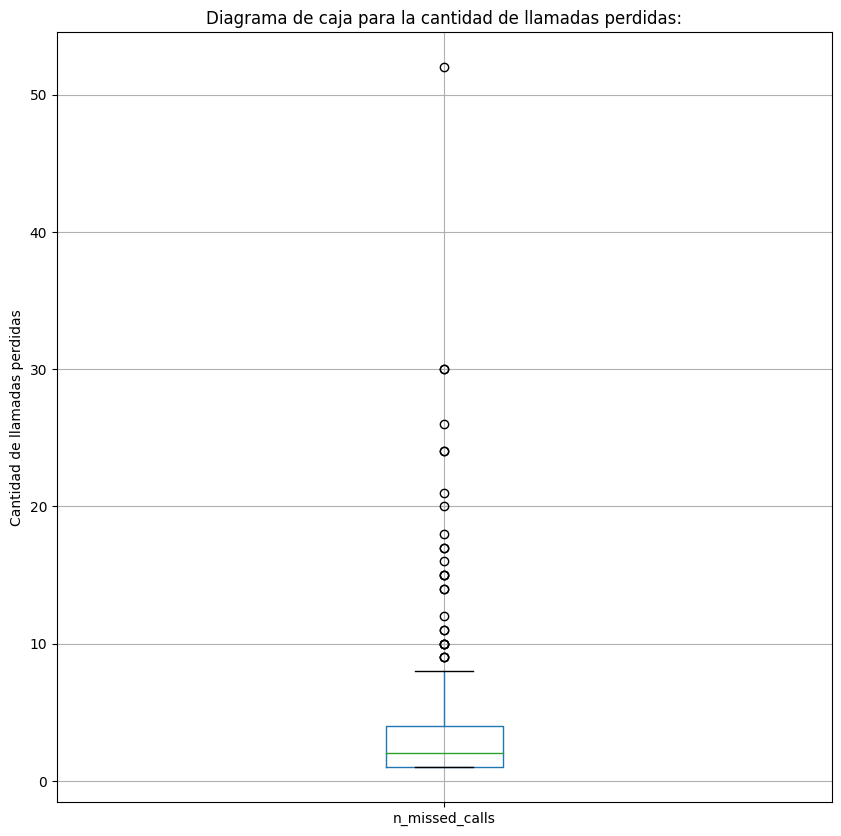

In [30]:
# Se realiza un diagrama de caja para la cantidad de llamadas perdidas:

# Se configura el tamaño de la gráfica:
plt.figure(figsize=(10, 10))

# Se cargan los valores de la variable a la gráfica:
summary[['n_missed_calls']].boxplot()

# Se asigna el nombre de la gráfica:
plt.title("Diagrama de caja para la cantidad de llamadas perdidas:")

# Se asigna nombre al eje "y":
plt.ylabel("Cantidad de llamadas perdidas")

# Se muestra la gráfica:
plt.show()

#### Diagrama de caja del tiempo de espera de la llamadas entrantes para cada oeprador:

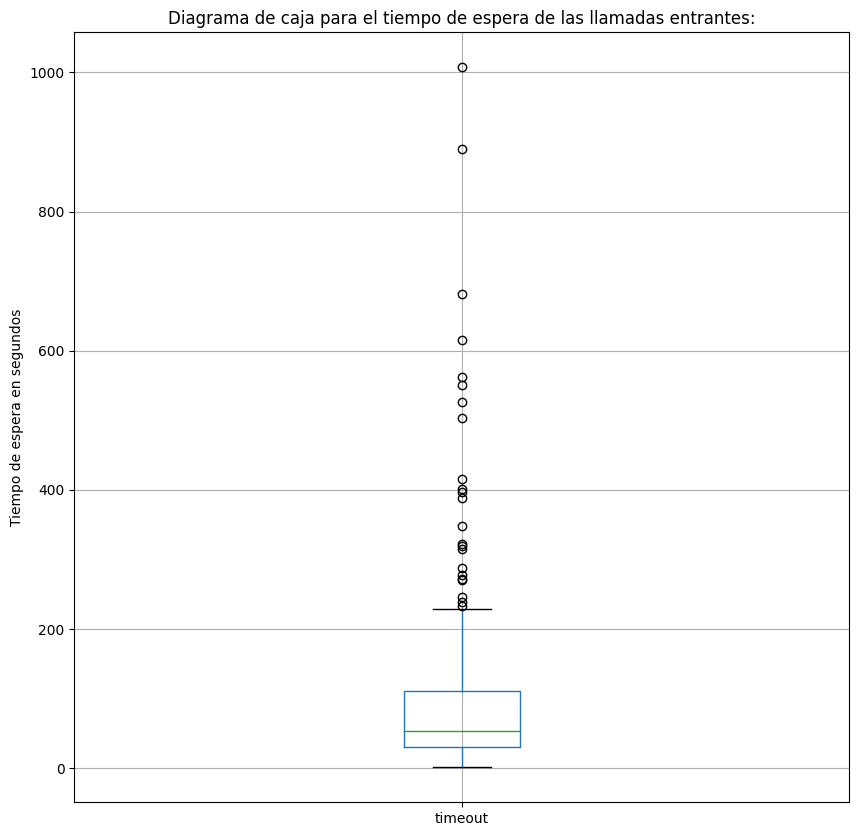

In [31]:
# Se realiza un diagrama de caja para el tiempo de espera de las llamadas entrantes:

# Se configura el tamaño de la gráfica:
plt.figure(figsize=(10, 10))

# Se cargan los valores de la variable a la gráfica:
summary[['timeout']].boxplot()

# Se asigna el nombre de la gráfica:
plt.title("Diagrama de caja para el tiempo de espera de las llamadas entrantes:")

# Se asigna nombre al eje "y":
plt.ylabel("Tiempo de espera en segundos")

# Se muestra la gráfica:
plt.show()

#### Diagrama de caja de la cantidad de llamadas salientes para cada oeprador:

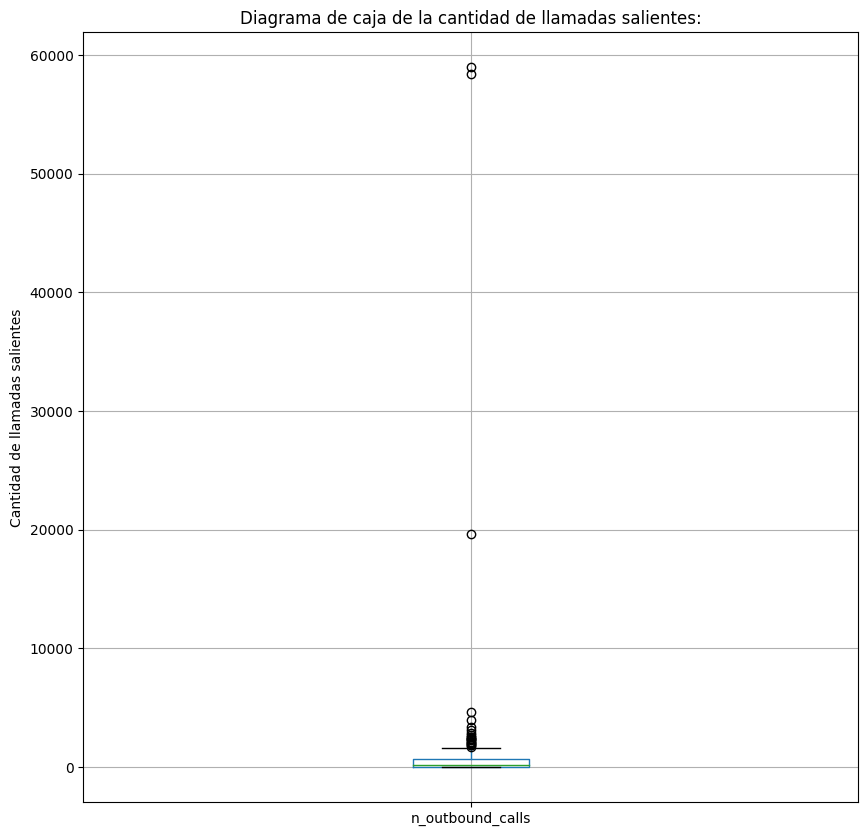

In [32]:
# Se realiza un diagrama de caja para el tiempo de espera de las llamadas entrantes:

# Se configura el tamaño de la gráfica:
plt.figure(figsize=(10, 10))

# Se cargan los valores de la variable a la gráfica:
summary[['n_outbound_calls']].boxplot()

# Se asigna el nombre de la gráfica:
plt.title("Diagrama de caja de la cantidad de llamadas salientes:")

# Se asigna nombre al eje "y":
plt.ylabel("Cantidad de llamadas salientes")

# Se muestra la gráfica:
plt.show()

**Conclisuiones:** Al igual que lo antes mencionado en las conclusiones del describe, se puede observar que todas las variables tienen sesgo hacia la derecha.

### Se establece el rango de valores crítico para cada variable:

#### Cantidad de llamadas entrantes perdidas:

Se procede a definir el límite máximo de llamadas perdidas para considerar al trabajador como eficaz en el bigote superior de la gráfica de caja (al tratarse de una variable discreta, se redeondeará el valor hacia arriba dando así un poco más de tolerancia a los operadores).

In [33]:
# Se calcula el bigote superior de la gráfica de caja de la cantidad de llamadas perdidas
whisker_missed = (mt.ceil(np.percentile(summary['n_missed_calls'], 75) + (np.percentile(summary['n_missed_calls'], 75)
                                                                  - np.percentile(summary['n_missed_calls'], 25)) * 1.5))

# Se muestra el límite máximo de llamadas perdidas:
print('La cantidad máxima de llamadas perdidas que se aceptarán para definir a un trabajador como eficaz, será de',
      whisker_missed, 'llamadas.')

La cantidad máxima de llamadas perdidas que se aceptarán para definir a un trabajador como eficaz, será de 9 llamadas.


#### Tiempo de espera para las llamadas entrantes:

Se procede a definir el límite máximo de tiempo de espera para las llamadas entrantes para considerar al trabajador como eficaz en el bigote superior de la gráfica de caja.

In [34]:
# Se calcula el bigote superior de la gráfica de caja del tiempo de espera de las llamadas entrantes:
whisker_timeout = (np.percentile(summary['timeout'], 75) + (np.percentile(summary['timeout'], 75)
                                                                  - np.percentile(summary['timeout'], 25)) * 1.5).round(2)

# Se muestra el límite máximo de llamadas perdidas:
print('El tiempo de espara máximo para las llamadas entrantes que se aceptará para definir a un trabajador como efizaz,',
      'será de', whisker_timeout, 'segundos.')

El tiempo de espara máximo para las llamadas entrantes que se aceptará para definir a un trabajador como efizaz, será de 232.5 segundos.


#### Cantidad de llamadas salientes:

Se procede a definir el límite mínimo de la cantidad de llamadas salientes para considerar al trabajador como eficaz.

Debido a que, realizando el cálculo del bigote inferior de la gráfica de caja se obtiene un valor negativo (ya que el rango intercuartílico es muy grande respecto al valor del primer cuartil) y debido a que el primer cuartil se ubica en 53 llamadas salientes; con el fin de no calificar un alto porcentaje de trabajadores como ineficaces, se decide establecer el límite inferior admisible para considerar a los trabajadores como eficaces en el punto medio entre el mínimo de llamadas y el primer cuartil.

In [35]:
# Se calcula el límite inferior para la cantidad mínima de llamadas salientes:
min_outbound = mt.ceil((np.percentile(summary['n_outbound_calls'], 25) + summary['n_outbound_calls'].min()) / 2)

# Se muestra el límite inferior para la cantidad de llamadas salientes:
print('La cantidad de llamadas salientes mínimas que se aceptará para definir a un trabajador eficaz será de', min_outbound)

La cantidad de llamadas salientes mínimas que se aceptará para definir a un trabajador eficaz será de 8


### Se define si el operador es ineficaz:

In [36]:
# Se determina si cada trabajador es o no ineficaz según las condiciones ya establecidas:
summary['ineficaz'] = ((summary['n_missed_calls'] > whisker_missed) |
                       (summary['timeout'] > whisker_timeout) |
                      (summary['n_outbound_calls'] < min_outbound))

# Se muestra la tabla con el resumen de la información de los trabajadores:
print('Tabla resumen con la información general:')
summary

Tabla resumen con la información general:


,operator_id,n_missed_calls,timeout,n_outbound_calls,ineficaz
0,882680,3,37.000000,0.0,True
1,882684,4,190.520000,661.0,False
2,882686,6,165.750000,2884.0,False
3,882690,2,322.818182,1417.0,True
4,884408,4,66.000000,25.0,False
...,...,...,...,...,...
234,959312,7,32.153846,145.0,False
235,960620,1,74.800000,58.0,False
236,964510,2,25.000000,131.0,False
237,964666,3,64.222222,814.0,False


In [37]:
# se muestra el porcentaje de trabajadores ineficaces:
print('El porcentaje de trabajadores que son ineficaces, es',(summary['ineficaz'].mean() * 100).round(2),'%')

El porcentaje de trabajadores que son ineficaces, es 36.82 %


## Pruebas de hipótesis estadísticas:

In [38]:
# Se unen los dataframe:
df = pd.merge(filtred_data, clients, how = 'left', on = 'user_id')
df = pd.merge(df, summary[['operator_id', 'ineficaz']], how = 'left', on = 'operator_id')

### Se filtran los operadores sin valores ausentes en la columna 'Ineficaz':

In [39]:
df_filtred = df[~df['ineficaz'].isna()].reset_index(drop = True)
df_filtred

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,timeout,tariff_plan,date_start,ineficaz
0,166405,2019-08-06 00:00:00+03:00,out,False,882684,False,1,11,24,13,B,2019-08-02,False
1,166405,2019-08-06 00:00:00+03:00,out,False,882684,True,1,0,8,8,B,2019-08-02,False
2,166405,2019-08-12 00:00:00+03:00,out,False,882684,True,1,0,74,74,B,2019-08-02,False
3,166405,2019-08-15 00:00:00+03:00,out,False,882684,False,1,151,153,2,B,2019-08-02,False
4,166405,2019-08-15 00:00:00+03:00,out,False,882686,True,2,0,61,61,B,2019-08-02,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18824,168606,2019-11-09 00:00:00+03:00,out,False,957922,False,4,551,593,42,C,2019-10-31,False
18825,168606,2019-11-10 00:00:00+03:00,out,True,957922,False,1,0,25,25,C,2019-10-31,False
18826,168606,2019-11-10 00:00:00+03:00,out,True,957922,True,1,0,38,38,C,2019-10-31,False
18827,168606,2019-11-11 00:00:00+03:00,out,True,957922,False,2,479,501,22,C,2019-10-31,False


**Conclusión:** Al filtrar los datos de los que no se tienen valores ausentes en la columna 'Ineficaz' se tiene un total de 18829 datos.

### Se cuenta la cantidad de operadores para cada grupo:

In [40]:
df_filtred.groupby('ineficaz')['operator_id'].nunique()

ineficaz
False    151
True      88
Name: operator_id, dtype: int64

**Conclusión:** Al comparar la cantidad de operadores ineficaces y los eficaces, se observa que no se encuentran balanceadas las muestras por lo que se procede a separar una muestra aleatoria del grupo de trabajadores eficaces.

### Se obtiene el id de 75 trabajadores eficaces para tener las muestras balanceadas:

In [41]:
# Se escogen 75 trabajadores al azar pertenecientes al grupo de trabajadores eficaces:
df_eficaces = df_filtred[df_filtred['ineficaz'] == False]['operator_id'].sample(n = 75, random_state = 0)

### Se filtran los operarios que van a formar parte de la muestras para las pruebas:

In [42]:
df_test = df_filtred[(df_filtred['operator_id'].isin(df_eficaces)) | (df_filtred['ineficaz'] == True)]

### Comparar las varianzas de duración de llamadas para los trabajadores eficaces e ineficaces:

Se realiza una prueba levene para comparar las varianzas de duración de las llamadas para ambos planes:

In [43]:
# Prueba levene para comparar las varianzas de los 2 planes:

# Se define la hipótesis nula y la hipótesis alternativa:
# H0: Las varianzas para ambos planes son iguales.
# HA: Las varianzas para ambos planes son distintas.
# Se selecciona el alpha:
alpha = .05

# Se realiza la prueba levene:
result = st.levene(df_test[df_test['ineficaz'] == False]['calls_duration'],
                   df_test[df_test['ineficaz'] == True]['calls_duration'])

# Se determina si se acepta o se rechaza la hipótesis nula de acuerdo al valor de p:
if result[1] < alpha:
    witness = False
    print('Se rechaza la hipotesis nula; estos es, las varianzas son distintas.\n')
else:
    witness = True
    print('Se acepta la hipotesis nula; esto es, las varianzas son iguales.\n')

print('El estadístico de prueba es', result[0], 'y el valor p es', result[1])

Se rechaza la hipotesis nula; estos es, las varianzas son distintas.

El estadístico de prueba es 179.2732980169048 y el valor p es 1.39050019294375e-40


### Comparar las medias de la duración de llamadas de los operadores eficaces y los ineficaces:

In [44]:
# Prueba ttest_ind para comparar las medias de los 2 planes:

# Se define la hipótesis nula y la hipótesis alternativa:
# H0: Las medias para ambos grupos son iguales.
# HA: Las medias para ambos grupos son distintas.
# Se selecciona el alpha:
alpha = .05

# Se realiza la prueba levene:
result = st.ttest_ind(df_test[df_test['ineficaz'] == False]['calls_duration'],
                      df_test[df_test['ineficaz'] == True]['calls_duration'],
                      equal_var = witness)

# Se determina si se acepta o se rechaza la hipótesis nula de acuerdo al valor de p:
if result[1] < alpha:
    print('Se rechaza la hipotesis nula; estos es, las medias son distintas.\n')
else:
    print('Se acepta la hipotesis nula; esto es, las medias son iguales.\n')

print('El estadístico de prueba es', result[0], 'y el valor p es', result[1],'\n')

print('La duración media de las llamadas de los operadores eficaces, es', df_test[df_test['ineficaz'] == False]['call_duration'].mean().round(2),
      'segundos.\n')

print('La duración media de las llamadas de los operadores ineficaces, es', df_test[df_test['ineficaz'] == True]['call_duration'].mean().round(2),
      'segundos.')

Se rechaza la hipotesis nula; estos es, las medias son distintas.

El estadístico de prueba es -12.783573439218216 y el valor p es 6.411018514427744e-37 

La duración media de las llamadas de los operadores eficaces, es 680.18 segundos.

La duración media de las llamadas de los operadores ineficaces, es 2412.24 segundos.


**Conclusiones:**

* Al realizar la prueba levene se evidencia que existe diferencia en las varianzas de la duración de las llamadas de los operadores eficaces y los ineficaces.

* Al realizar el ttest_ind se puede observar que existen diferencias en las medias de la duración de las llamadas de para ambos grupos de operadores.

* La **duración media de las llamadas** para los operadores **eficaces** es de **818.03 segundos**.

* La **duración media de las llamadas** para los operadores **ineficacesB** es de **2726.94 segundos**.

* Se puede concluir que la **duración media de las llamadas de los operadores ineficaces** es más del **triple**  de la duración media de las llamadas de los **operadores eficaces**.

### Comparar las varianzas de la cantidad de llamadas de los operadores eficaces e ineficaces:

In [47]:
# Prueba levene para comparar las varianzas de los 2 planes:

# Se define la hipótesis nula y la hipótesis alternativa:
# H0: Las varianzas para ambos planes son iguales.
# HA: Las varianzas para ambos planes son distintas.
# Se selecciona el alpha:
alpha = .05

# Se realiza la prueba levene:
result = st.levene(df_test[(df_test['ineficaz'] == False) & (df_test['direction']=='out')]['calls_count'],
                   df_test[(df_test['ineficaz'] == True) & (df_test['direction']=='out')]['calls_count'])

# Se determina si se acepta o se rechaza la hipótesis nula de acuerdo al valor de p:
if result[1] < alpha:
    witness = False
    print('Se rechaza la hipotesis nula; estos es, las varianzas son distintas.\n')
else:
    witness = True
    print('Se acepta la hipotesis nula; esto es, las varianzas son iguales.\n')

print('El estadístico de prueba es', result[0], 'y el valor p es', result[1])

Se rechaza la hipotesis nula; estos es, las varianzas son distintas.

El estadístico de prueba es 483.59970066907334 y el valor p es 2.446918426003169e-103


### Comparar las medias de la cantidad de llamadas de los operadores eficaces e ineficaces:

In [46]:
# Prueba ttest_ind para comparar las medias de los 2 planes:

# Se define la hipótesis nula y la hipótesis alternativa:
# H0: Las medias para ambos grupos son iguales.
# HA: Las medias para ambos grupos son distintas.
# Se selecciona el alpha:
alpha = .05

# Se realiza la prueba levene:
result = st.ttest_ind(df_test[(df_test['ineficaz'] == False) & (df_test['direction']=='out')]['calls_count'],
                      df_test[(df_test['ineficaz'] == True) & (df_test['direction']=='out')]['calls_count'],
                      equal_var = witness)

# Se determina si se acepta o se rechaza la hipótesis nula de acuerdo al valor de p:
if result[1] < alpha:
    print('Se rechaza la hipotesis nula; estos es, las medias son distintas.\n')
else:
    print('Se acepta la hipotesis nula; esto es, las medias son iguales.\n')

print('El estadístico de prueba es', result[0], 'y el valor p es', result[1],'\n')

print('La media de la cantidad de llamadas de los operadores eficaces, es', df_test[df_test['ineficaz'] == False]['calls_count'].mean().round(2))

print('La media de la cantidad de llamadas de los operadores ineficaces, es', df_test[df_test['ineficaz'] == True]['calls_count'].mean().round(2))

Se rechaza la hipotesis nula; estos es, las medias son distintas.

El estadístico de prueba es -16.62609441124096 y el valor p es 1.0588657641386876e-58 

La media de la cantidad de llamadas de los operadores eficaces, es 8.52
La media de la cantidad de llamadas de los operadores ineficaces, es 36.79


**Conclusión:**

* Al realizar las pruebas de comparación de varianzas y de medias, se puede observar que en ambas pruebas se rechaza la hipótesis nula, o sea, que tanto las varianzas como las medias son distintas para ambos grupos de operadores.

* Al comparar la media de la cantidad de llamadas para cada grupo de operadores se puede observar que la media de los operadores ineficaces cuadriplica a la media de los trabajadores eficaces, esto podría ser un punto a favor de los trabajadores ineficaces.

* Para acceder al dashboard use el siguiente vínculo https://public.tableau.com/app/profile/joan.manuel.sanchez.sandia/viz/ProyectoSprint14/Dashboard1?publish=yes

* Para acceder a la presentación en pdf use el siguiente vínculo https://drive.google.com/file/d/1nq5KtJZFifkRA5TB6WDyixPxjWfNX3R_/view?usp=drive_link

* Para acceder a la presentación en pptx use el siguiente vínculo
https://docs.google.com/presentation/d/12o5bgu73atdnak31q_E1IJeOo3MN5rhO/edit?usp=drive_link&ouid=105910490680525495676&rtpof=true&sd=true